# Problem Statement

Imagine you have a dataset where you have predicted loan Eligibility using any
4 different classification algorithms. 

Now you have to build a model which can
predict loan Eligibility and you need to find the accuracy of the model and 

built-in
docker and use some library to display that in frontend.

## Dataset

Link : https://www.kaggle.com/datasets/ninzaami/loan-predication/download?datasetVersionNumber=1

# Required Libraries

In [170]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
%matplotlib inline
import seaborn as sns
from scipy.stats import boxcox
from scipy.stats import skew, kurtosis
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.feature_selection import SelectKBest, f_classif

# Data Ingestion

In [171]:
file_path = "loan_eligibility.csv"

df = pd.read_csv(file_path)

In [172]:
df.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y


# EDA & FE

## Basic info about Dataset

In [173]:
print(f"No of Rows = {df.shape[0]}\nNo of columns = {df.shape[1]}")

No of Rows = 614
No of columns = 13


In [174]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 614 entries, 0 to 613
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Loan_ID            614 non-null    object 
 1   Gender             601 non-null    object 
 2   Married            611 non-null    object 
 3   Dependents         599 non-null    object 
 4   Education          614 non-null    object 
 5   Self_Employed      582 non-null    object 
 6   ApplicantIncome    614 non-null    int64  
 7   CoapplicantIncome  614 non-null    float64
 8   LoanAmount         592 non-null    float64
 9   Loan_Amount_Term   600 non-null    float64
 10  Credit_History     564 non-null    float64
 11  Property_Area      614 non-null    object 
 12  Loan_Status        614 non-null    object 
dtypes: float64(4), int64(1), object(8)
memory usage: 62.5+ KB


**Observations:**

1. The data set contain 12 Independent features and one target feature i.e. Loan_Status.

2. Out of 12 independent features 7 are categorical and 5 are Numerical.

3. Loan_ID is just a label and unique for each row. It has very little relationship with the loan status. We should drop it.

4. Remaining 6 categorical features need to be encoded into Numerical variables.

## Numerical and Categorical Features

In [175]:
num_col = df.select_dtypes(['int64', 'float64']).columns.to_list()
cat_col = df.select_dtypes('object').columns.to_list()

print(f"Numeric columns : {num_col}\nCategorical columns : {cat_col}")

Numeric columns : ['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount', 'Loan_Amount_Term', 'Credit_History']
Categorical columns : ['Loan_ID', 'Gender', 'Married', 'Dependents', 'Education', 'Self_Employed', 'Property_Area', 'Loan_Status']


## Data Cleaning

### Handle missing values

In [176]:
# Check for missing values and calculate the percentage of missing values
missing_values = df.isnull().sum()
missing_percentage = (missing_values / len(df)) * 100

# Columns with missing values and their percentages
columns_with_missing_values = missing_percentage[missing_percentage > 0]

columns_with_missing_values.sort_values(ascending=False).round(2)

Credit_History      8.14
Self_Employed       5.21
LoanAmount          3.58
Dependents          2.44
Loan_Amount_Term    2.28
Gender              2.12
Married             0.49
dtype: float64

**Observations:**

- We can see in the above list that following features have some missing values:

        - Credit_History       8.14

        - Self_Employed        5.21

        - LoanAmount           3.58

        - Dependents           2.44

        - Loan_Amount_Term     2.28

        - Gender               2.12
        
        - Married              0.49

- As the dataset have only 600+ observations, we can't drop all the missing observations. Instead we need to find some satistical approximations for each observation if possible.

- For Categorical features we will fill the missing values with mode of the respective column.

- For Numerical Features we will fill the missing values with mean or median values.

In [177]:
# Handling missing values

# Credit_History: Fill with the mode (most frequent value)
df['Credit_History'].fillna(df['Credit_History'].mode()[0], inplace=True)

# Self_Employed: Fill with the mode (most frequent value)
df['Self_Employed'].fillna(df['Self_Employed'].mode()[0], inplace=True)

# LoanAmount: Fill with the mean
df['LoanAmount'].fillna(df['LoanAmount'].mean(), inplace=True)

# Dependents: Fill with the mode (most frequent value)
df['Dependents'].fillna(df['Dependents'].mode()[0], inplace=True)

# Loan_Amount_Term: Fill with the median
df['Loan_Amount_Term'].fillna(df['Loan_Amount_Term'].median(), inplace=True)

# Gender: Fill with the mode (most frequent value)
df['Gender'].fillna(df['Gender'].mode()[0], inplace=True)

# Married: Fill with the mode (most frequent value)
df['Married'].fillna(df['Married'].mode()[0], inplace=True)



In [178]:
# Verify if there are no more missing values
df.isnull().sum()

Loan_ID              0
Gender               0
Married              0
Dependents           0
Education            0
Self_Employed        0
ApplicantIncome      0
CoapplicantIncome    0
LoanAmount           0
Loan_Amount_Term     0
Credit_History       0
Property_Area        0
Loan_Status          0
dtype: int64

**Comment:**

Successfully handled all the missing values without removing them.

### Remove duplicates

In [179]:
df.duplicated().sum()

0

**No Duplicated rows found.**

### Deal with outliers

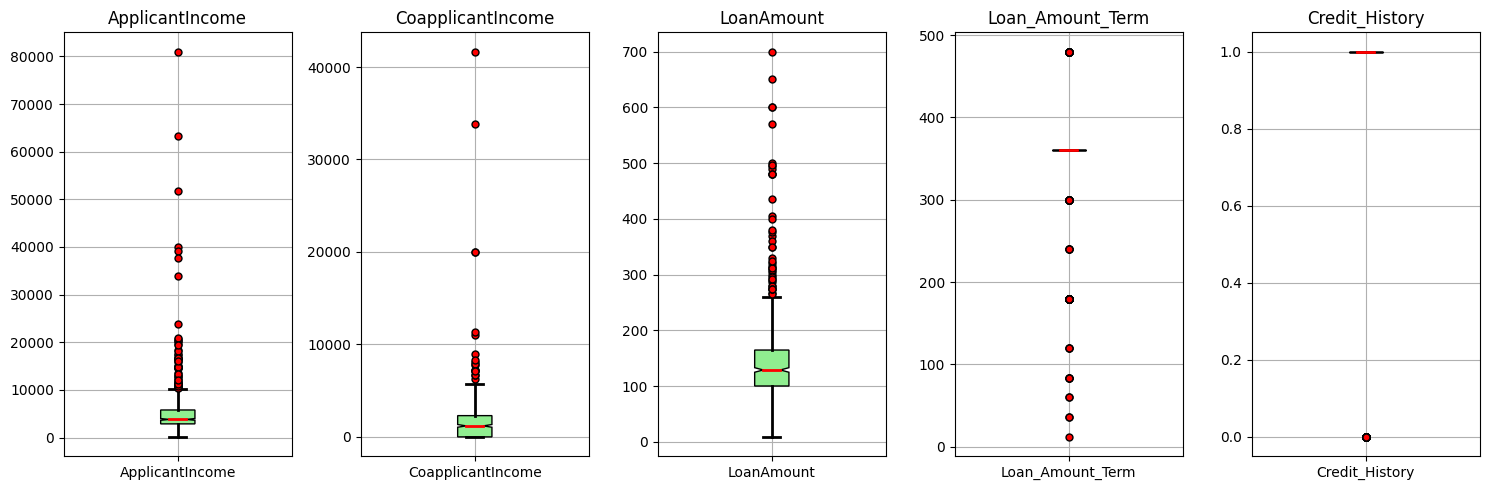

In [180]:
# Create a subplot grid for the boxplots
fig, axes = plt.subplots(nrows=1, ncols=len(num_col), figsize=(15, 5))

# Iterate over the numerical columns and create boxplots in each subplot
for i, column in enumerate(num_col):
    ax = axes[i]  # Select the current subplot
    # Create the boxplot for the current column
    boxplot = df.boxplot(column=column, ax=ax, patch_artist=True, notch=True,
                         whiskerprops=dict(linewidth=2),
                         capprops=dict(linewidth=2),
                         medianprops=dict(linewidth=2, color='red'),
                         boxprops=dict(facecolor='lightgreen', color='black'),
                         flierprops=dict(marker='o', markersize=5, markerfacecolor='red'))
    
    ax.set_title(column)  # Set the title of the subplot
    
# Adjust the spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()

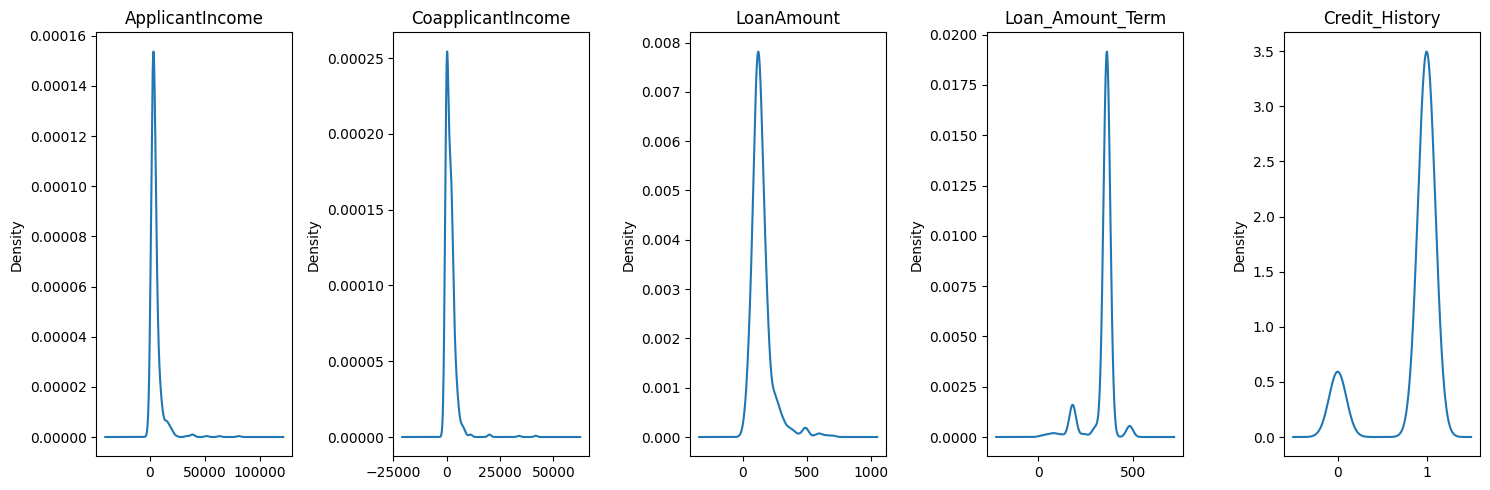

In [181]:
# Create a subplot grid for the kdeplots
fig, axes = plt.subplots(nrows=1, ncols=len(num_col), figsize=(15, 5))

# Iterate over the numerical columns and create kdeplots in each subplot
for i, column in enumerate(num_col):
    ax = axes[i]  # Select the current subplot
    # Create the kdeplot for the current column
    df[column].plot(kind='kde', ax=ax)
    
    ax.set_title(column)  # Set the title of the subplot
    
# Adjust the spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()

**Observations:**

1. Credit History has binary distribution. So don't need to do anything special to handle the outliers.
2. We can see few negative values in CoapplicantIncome, which is not acceptable. We must convert them to positive

#### Hndleing Outlier using Transformers

1) logarithmic transformation, 

2) square root transformation, 

3) Box-Cox transformation.

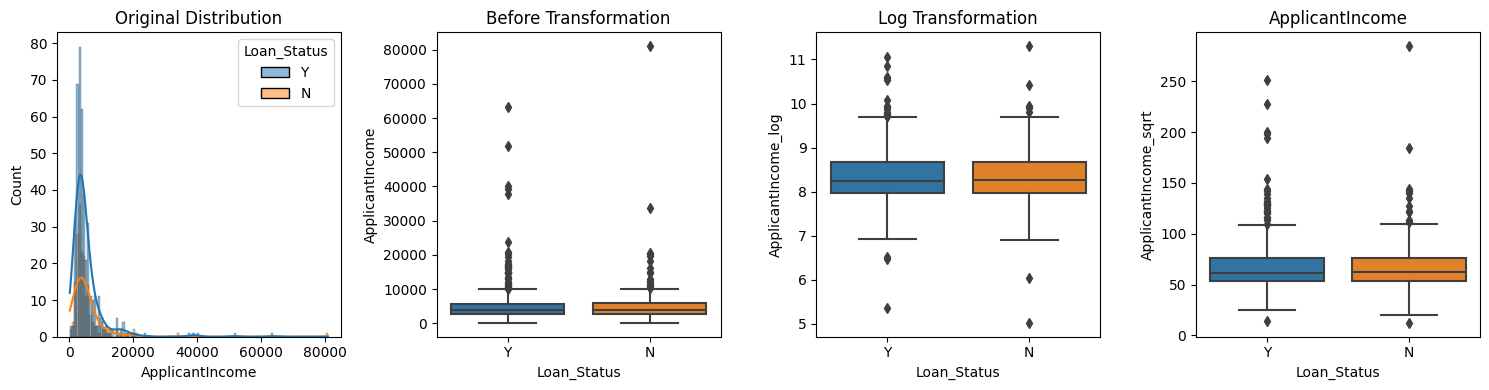

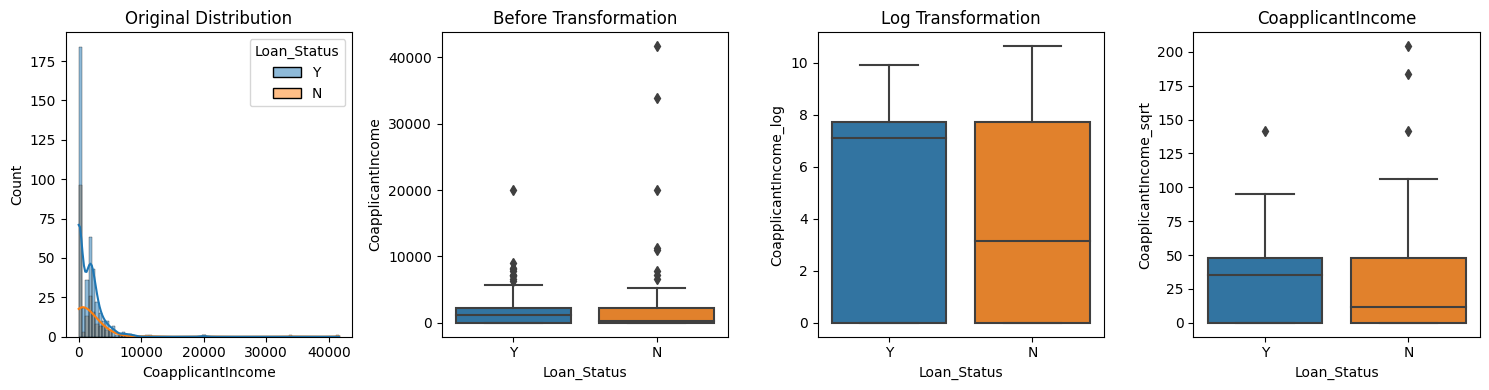

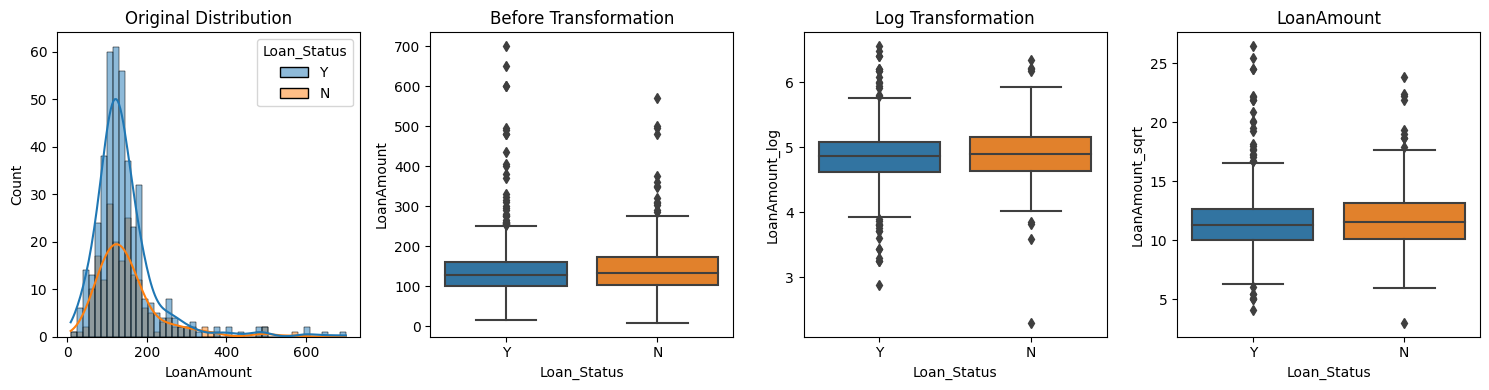

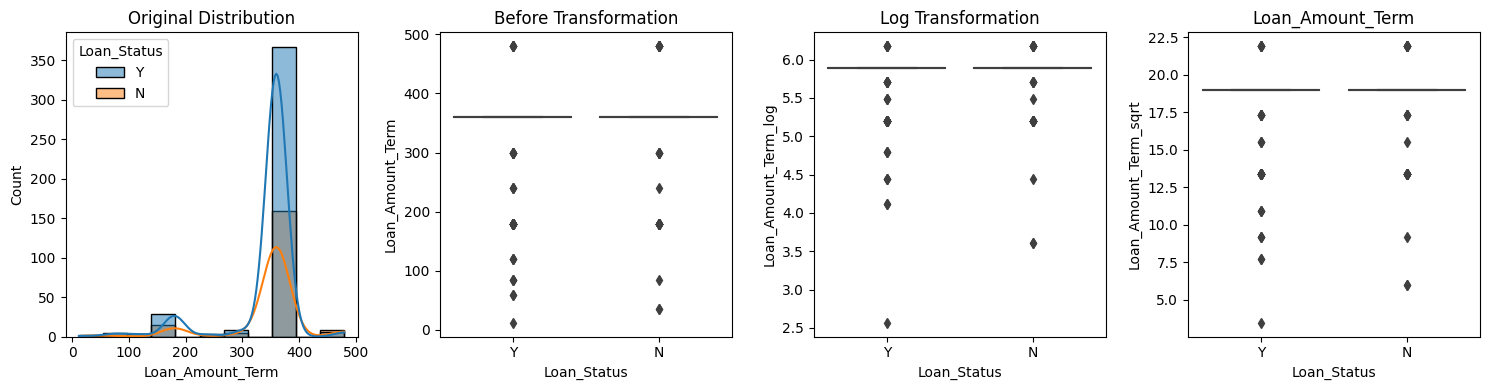

Column: ApplicantIncome
Log Transformation: Mean Difference = 0.0152, Std Difference = 0.0489
Square Root Transformation: Mean Difference = 0.1047, Std Difference = 1.4586

Column: CoapplicantIncome
Log Transformation: Mean Difference = 0.5062, Std Difference = 0.1609
Square Root Transformation: Mean Difference = 0.5496, Std Difference = 6.784

Column: LoanAmount
Log Transformation: Mean Difference = 0.0446, Std Difference = 0.0108
Square Root Transformation: Mean Difference = 0.2711, Std Difference = 0.0397

Column: Loan_Amount_Term
Log Transformation: Mean Difference = 0.0055, Std Difference = 0.0139
Square Root Transformation: Mean Difference = 0.069, Std Difference = 0.1416



In [182]:
# Define the target variable
target_col = 'Loan_Status'

# Create a list of transformation columns to evaluate
transform_cols = ['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount', 'Loan_Amount_Term']

# Initialize a dictionary to store the evaluation results
transform_results = {}

# Loop through each transformation column
for col in transform_cols:
    # Apply log transformation
    df[col+'_log'] = np.log1p(df[col])
    
    # Apply square root transformation
    df[col+'_sqrt'] = np.sqrt(df[col])
    
    # Plot the distributions and boxplots for each transformation
    fig, axes = plt.subplots(1, 4, figsize=(15, 4))
    
    # Plot the original distribution
    sns.histplot(data=df, x=col, hue=target_col, kde=True, ax=axes[0])
    axes[0].set_title('Original Distribution')
    
    # Plot the boxplots for each transformation
    sns.boxplot(x=target_col, y=col, data=df, ax=axes[1])
    axes[1].set_title('Before Transformation')
    
    sns.boxplot(x=target_col, y=col+'_log', data=df, ax=axes[2])
    axes[2].set_title('Log Transformation')

    sns.boxplot(x=target_col, y=col+'_sqrt', data=df, ax=axes[3])
    axes[3].set_title('Square Root Transformation')
    
    plt.tight_layout()
    plt.title(col)
    plt.show()
    
    # Calculate statistical measures for each transformation
    log_mean_diff = df.groupby(target_col)[col+'_log'].mean().diff().abs().values[-1]
    sqrt_mean_diff = df.groupby(target_col)[col+'_sqrt'].mean().diff().abs().values[-1]
    log_std_diff = df.groupby(target_col)[col+'_log'].std().diff().abs().values[-1]
    sqrt_std_diff = df.groupby(target_col)[col+'_sqrt'].std().diff().abs().values[-1]
    
    # Store the evaluation results in the dictionary
    transform_results[col] = {
        'Log Transformation': (log_mean_diff, log_std_diff),
        'Square Root Transformation': (sqrt_mean_diff, sqrt_std_diff)
    }

# Print the evaluation results
for col, results in transform_results.items():
    print(f"Column: {col}")
    for transform, (mean_diff, std_diff) in results.items():
        print(f"{transform}: Mean Difference = {mean_diff.round(4)}, Std Difference = {std_diff.round(4)}")
    print()


**Observations:**

By analysing the above plots and transformation results, we can see that the log transformations works best with our dataset.

We must keep the log transformation columns only and remove the original and sqrt transformed columns.

In [183]:
for col in transform_cols:
    df.drop(columns=[col, col+'_sqrt'], inplace=True)

In [184]:
df.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,Credit_History,Property_Area,Loan_Status,ApplicantIncome_log,CoapplicantIncome_log,LoanAmount_log,Loan_Amount_Term_log
0,LP001002,Male,No,0,Graduate,No,1.0,Urban,Y,8.674197,0.000000,4.993232,5.888878
1,LP001003,Male,Yes,1,Graduate,No,1.0,Rural,N,8.430327,7.319202,4.859812,5.888878
2,LP001005,Male,Yes,0,Graduate,Yes,1.0,Urban,Y,8.006701,0.000000,4.204693,5.888878
3,LP001006,Male,Yes,0,Not Graduate,No,1.0,Urban,Y,7.857094,7.765993,4.795791,5.888878
4,LP001008,Male,No,0,Graduate,No,1.0,Urban,Y,8.699681,0.000000,4.955827,5.888878


### Resolve inconsistencies

In [185]:
###

## Encoding Categorical features

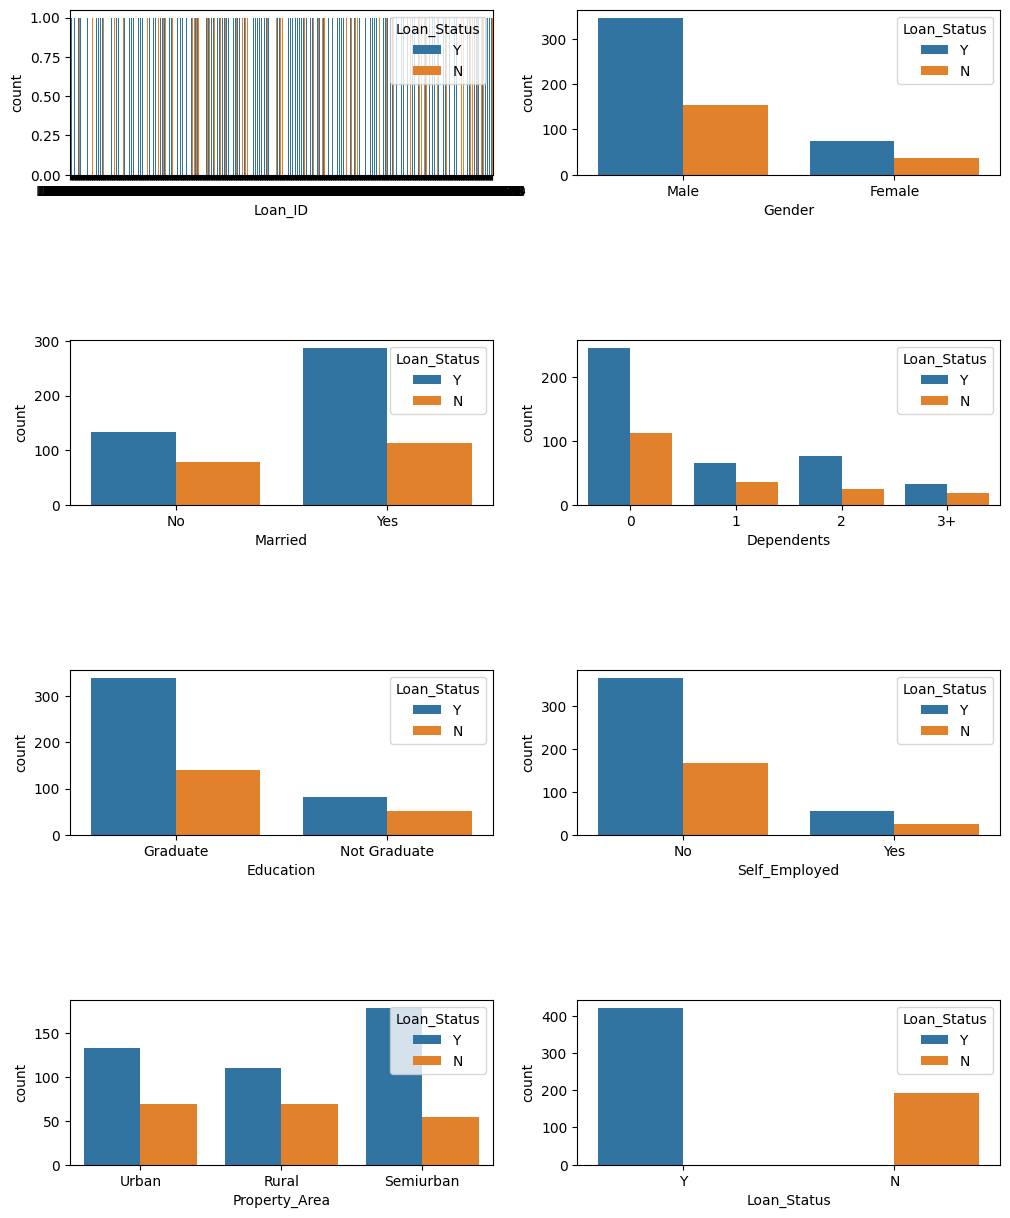

In [186]:
fig,axes = plt.subplots(4,2,figsize=(12,15))
for idx,cat_col in enumerate(cat_col):
    row,col = idx//2,idx%2
    sns.countplot(x=cat_col,data=df,hue='Loan_Status',ax=axes[row,col])


plt.subplots_adjust(hspace=1)

<Axes: xlabel='Loan_ID', ylabel='Loan_Status'>

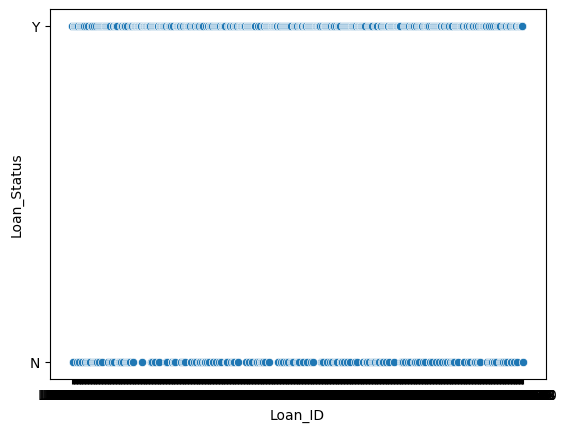

In [187]:
sns.scatterplot(df, x='Loan_ID', y='Loan_Status')

**Observations:**

- **Loan_ID**: As there is no usefull relation between the Loan_ID and Loan_Status, we must drop Loan_ID column.
- **Gender**: There are more Men than Women (approx. 3x)
- **Martial Status**: 2/3rd of the population in the dataset is Marred; Married applicants are more likely to be granted loans.
- **Dependents**: Majority of the population have zero dependents and are also likely to accepted for loan.
- **Education**: About 5/6th of the population is Graduate and graduates have higher propotion of loan approval
- **Employment**: 5/6th of population is not self employed.
- **Property Area**: More applicants from Semi-urban and also likely to be granted loans.
- **Loan Amount Term**: Majority of the loans taken are for 360 Months (30 years).
- **Loan Approval Status**: About 2/3rd of applicants have been granted loan.

In [188]:
df.drop(columns=['Loan_ID'], inplace=True)

In [189]:
cat_col = df.select_dtypes('object').columns.to_list()

In [190]:
cat_col

['Gender',
 'Married',
 'Dependents',
 'Education',
 'Self_Employed',
 'Property_Area',
 'Loan_Status']

In [191]:
for col in cat_col:
    print(f"Column : {col}\nUnique Values : {df[col].unique()}")

Column : Gender
Unique Values : ['Male' 'Female']
Column : Married
Unique Values : ['No' 'Yes']
Column : Dependents
Unique Values : ['0' '1' '2' '3+']
Column : Education
Unique Values : ['Graduate' 'Not Graduate']
Column : Self_Employed
Unique Values : ['No' 'Yes']
Column : Property_Area
Unique Values : ['Urban' 'Rural' 'Semiurban']
Column : Loan_Status
Unique Values : ['Y' 'N']


#### Label Encoding using map function


In [192]:
# Column : Gender || Unique Values : ['Male' 'Female']
df["Gender"] = df["Gender"].map({'Male':1, 'Female':0})

# Column : Married || Unique Values : ['No' 'Yes']
df["Married"] = df["Married"].map({'Yes':1, 'No':0})

# Column : Dependents || Unique Values : ['0' '1' '2' '3+']
df['Dependents'] = df["Dependents"].map({'0':0, '1':1, '2':2, '3+':3})

# Column : Education || Unique Values : ['Graduate' 'Not Graduate']
df["Education"] = df["Education"].map({'Graduate':1, 'Not Graduate':0})

# Column : Self_Employed || Unique Values : ['No' 'Yes']
df['Self_Employed'] = df["Self_Employed"].map({'Yes':1, 'No':0})

# Column : Property_Area || Unique Values : ['Urban' 'Rural' 'Semiurban']
df['Property_Area'] = df["Property_Area"].map({'Urban':3, 'Semiurban':2, 'Rural':1})

# Column : Loan_Status || Unique Values : ['Y' 'N']
df['Loan_Status'] = df["Loan_Status"].map({'Y':1, 'N':0})


In [193]:
df.head()

,Gender,Married,Dependents,Education,Self_Employed,Credit_History,Property_Area,Loan_Status,ApplicantIncome_log,CoapplicantIncome_log,LoanAmount_log,Loan_Amount_Term_log
0,1,0,0,1,0,1.0,3,1,8.674197,0.000000,4.993232,5.888878
1,1,1,1,1,0,1.0,1,0,8.430327,7.319202,4.859812,5.888878
2,1,1,0,1,1,1.0,3,1,8.006701,0.000000,4.204693,5.888878
3,1,1,0,0,0,1.0,3,1,7.857094,7.765993,4.795791,5.888878
4,1,0,0,1,0,1.0,3,1,8.699681,0.000000,4.955827,5.888878


## Final checking for missing values

In [194]:
df.isna().sum()

Gender                   0
Married                  0
Dependents               0
Education                0
Self_Employed            0
Credit_History           0
Property_Area            0
Loan_Status              0
ApplicantIncome_log      0
CoapplicantIncome_log    0
LoanAmount_log           0
Loan_Amount_Term_log     0
dtype: int64

# Feature Selection

# Feature Seperation

# Train-Test Split

# Model Initiation

# Model Training

# Model Performance and Selection